# U.S. Medical Insurance Costs

## Project Scoping
### Goals:
- Find out which factors in our dataset are the biggest determinants of insurance cost.
- Find out which factors are negatively correlated with insurance cost (which make costs go down) and positively correlated.
### Hypotheses:
- Factors that increase insurance costs: smoking, higher age, higher BMI, being Female
- Smoking is the biggest determinant of insurance cost (has the most influence over insurance cost)
### Steps in process:
1. Read in data
2. EDA and data cleaning:
    1. missing values?
    2. correct data types?
    3. descriptive stats
    4. identify outliers
    5. visualize data with histograms, box plots, correlation plots
3. Feature engineering
    1. convert categorical variables to numbers
    2. consider bucketing some features (BMI = underweight, normal, overweight, obese)
4. Split data into testing and training sets
5. Test some supervised learning algorithms to find the best performance
     1. linear regression
     2. decision tree
7. Draw conclusions

## Step 1: import packages, read in data

In [91]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

In [71]:
#read data
df = pd.read_csv('insurance.csv')
df.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

## Step 2: EDA and data cleaning:
- missing values?
- correct data types?
- descriptive stats
- identify outliers
- visualize data with histograms, box plots, correlation plots

In [7]:
#describe numeric features
df.describe()

age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

**age:**: mean and median are close, indicating that there probably aren't outliers skewing this feature; ages range from 18 to 64

**bmi**: mean and median are also close for this feature; BMIs range from ~16 to ~53

**children**: mean and median are close; range is 1-5 children

**charges**: the mean is much greater than the median, indicating that this feature is likely skewed to the high side; the range is also large, ~1,100 to ~64,000

In [9]:
#check for NaNs
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
#check data types
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [11]:
histograms = df.hist()

**age**: most ages are in the 20s

**bmi**: looks mostly normally distributed

**charges**: majorly skewed right; most values are 0-10,000, but there are values in the 40,000s, and at least one as high as 60,000

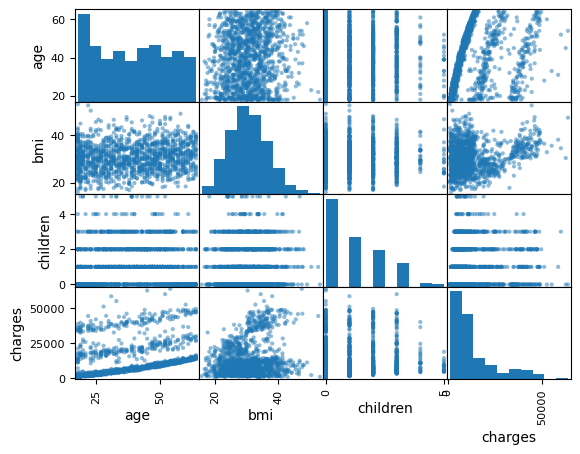

In [13]:
scatter_matrix = pd.plotting.scatter_matrix(df[['age', 'bmi', 'children', 'charges']])

based on the scatter plots, there aren't any strong correlations between the numerical features

In [15]:
#look at value counts to get a sense of how many people are in each category
print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


The sex and region features seem to have similar count for each category; smoker has many more non-smokers than smokers

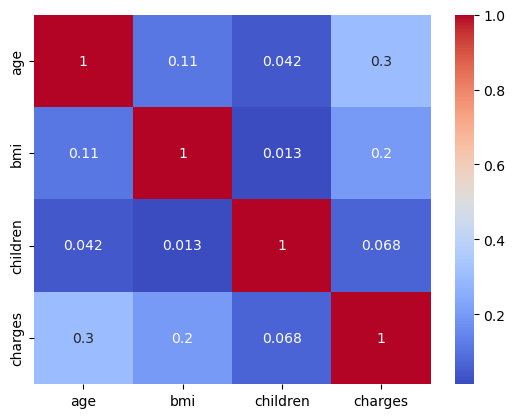

In [17]:
#check correlations between numberical variables
corr_matrix = df[['age', 'bmi', 'children', 'charges']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

There are no strong correlations in our data among numerical varibles, but age and charges are the most correlated with a correlation of 0.3. Because the correlation is positive, this means insurance cost (charges) increases as age increases.

## Step 3: Feature engineering
- convert categorical variables to numbers
- consider bucketing some features (BMI = underweight, normal, overweight, obese)

In [73]:
#add BMI categories following:
#Underweight: BMI is less than 18.5
#Normal weight: BMI is 18.5 to 24.9
#Overweight: BMI is 25 to 29.9
#Obese: BMI is 30 or more
def BMI_thresholds(bmi):
    if bmi < 18.5:
        #underweight
        return 'underweight'
    elif bmi < 24.9:
        #normal
        return 'normal'
    elif bmi < 29.9:
        #overweight
        return 'overweight'
    else:
        #obese
        return 'obese'
df['bmi_category'] = df['bmi'].apply(BMI_thresholds)
#df.head()

#convert categoricael to dummies
df_dummies = pd.get_dummies(df[['sex', 'smoker', 'region', 'bmi_category']], dtype=int)
#exclude one dummy from each category to be the reference
df_dummies = df_dummies[['sex_female', 'smoker_no', 'region_northeast', 'region_northwest', 'region_southeast', 
                        'bmi_category_normal', 'bmi_category_obese', 'bmi_category_overweight']]
df = pd.concat([df, df_dummies], axis=1)
df.head()

age     sex     bmi  children smoker     region      charges bmi_category  \
0   19  female  27.900         0    yes  southwest  16884.92400   overweight   
1   18    male  33.770         1     no  southeast   1725.55230        obese   
2   28    male  33.000         3     no  southeast   4449.46200        obese   
3   33    male  22.705         0     no  northwest  21984.47061       normal   
4   32    male  28.880         0     no  northwest   3866.85520   overweight   

   sex_female  smoker_no  region_northeast  region_northwest  \
0           1          0                 0                 0   
1           0          1                 0                 0   
2           0          1                 0                 0   
3           0          1                 0                 1   
4           0          1                 0                 1   

   region_southeast  bmi_category_normal  bmi_category_obese  \
0                 0                    0                   0   
1                 1                    0                   1   
2                 1                    0                   1   
3                 0                    1                   0   
4                 0                    0                   0   

   bmi_category_overweight  
0                        1  
1                        0  
2                        0  
3                        0  
4                        1

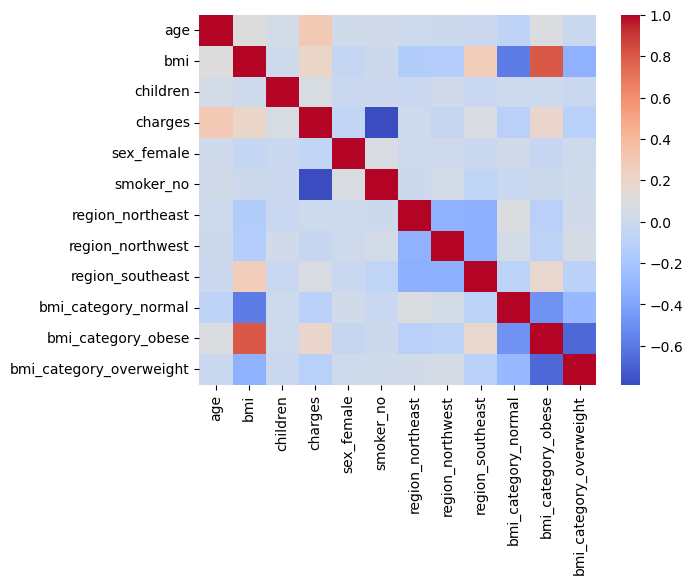

                              age       bmi  children   charges  sex_female  \
age                      1.000000  0.109272  0.042469  0.299008    0.020856   
bmi                      0.109272  1.000000  0.012759  0.198341   -0.046371   
children                 0.042469  0.012759  1.000000  0.067998   -0.017163   
charges                  0.299008  0.198341  0.067998  1.000000   -0.057292   
sex_female               0.020856 -0.046371 -0.017163 -0.057292    1.000000   
smoker_no                0.025019 -0.003750 -0.007673 -0.787251    0.076185   
region_northeast         0.002475 -0.138156 -0.022808  0.006349    0.002425   
region_northwest        -0.000407 -0.135996  0.024806 -0.039905    0.011156   
region_southeast        -0.011642  0.270025 -0.023066  0.073982   -0.017117   
bmi_category_normal     -0.078098 -0.591119  0.008216 -0.106512    0.024759   
bmi_category_obese       0.088600  0.797954  0.007158  0.194983   -0.038191   
bmi_category_overweight -0.017395 -0.324201 -0.01348

In [21]:
#try another correlation matrix that includes the categorical variables
corr_matrix = df[['age', 'bmi',	'children',	'charges', 'sex_female', 
                  'smoker_no', 'region_northeast', 'region_northwest', 
                  'region_southeast', 'bmi_category_normal', 
                  'bmi_category_obese', 'bmi_category_overweight']].corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()
print(corr_matrix)

The smoker category is highly correlated with insurance costs with a correlation of 0.79. The non-smoker category is negatively correlated meaning being a non-smoker lowers insurance costs.

## Step 4: Split data into testing and training sets and scale data

In [75]:
#y is our target
y = df['charges']
#x are our features
X = df[['age', 'bmi', 'children', 'sex_female', 'smoker_no', 
        'region_northeast', 'region_northwest', 'region_southeast', 
        'bmi_category_normal', 'bmi_category_obese', 'bmi_category_overweight']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state = 1)

print('size of y: ', len(y))
print('size of y_train: ', len(y_train))
print('size of y_test: ', len(y_test))

size of y:  1338
size of y_train:  1070
size of y_test:  268


In [77]:
dummies = ['sex_female', 'smoker_no', 'region_northeast', 'region_northwest', 'region_southeast', 
           'bmi_category_normal', 'bmi_category_obese', 'bmi_category_overweight']

#use MinMaxScaler instead of StandardScalar so the dummies remain binary
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(X_train)
#use same transformer on the test data
test_scaled = scaler.transform(X_test)

## Step 5: Test some supervised learning algorithms to find the best performance

### Linear regression

In [79]:
#initiate and train model
lr_model = LinearRegression()
lr_model.fit(train_scaled, y_train)

# Get the intercept and coefficients
intercept = lr_model.intercept_
coefficients = lr_model.coef_

#print the model info and R^2
print(intercept)
print(coefficients)
print(lr_model.score(train_scaled, y_train))

21002.91504142239
[ 1.18264968e+04  4.79465552e+03  2.07870930e+03  2.15877201e+02
 -2.38113891e+04  9.24846978e+02  4.88265400e+02  2.04638559e+01
  1.30296325e+03  4.22181694e+03  1.55413483e+03]
0.7521607663544329


In [81]:
#get errors for training data
mse = mean_squared_error(y_train, lr_model.predict(train_scaled))
rmse = sqrt(mse)
mae = mean_absolute_error(y_train, lr_model.predict(train_scaled))
mape = mean_absolute_percentage_error(y_train, lr_model.predict(train_scaled))
print('MSE =', mse)
print('RMSE =', rmse)
print('MAE =', mae)
print('MAPE =', mape)

MSE = 36147086.12593753
RMSE = 6012.244682806708
MAE = 4224.496847668018
MAPE = 0.4411800853099616


A mean absolute error of 4,224 means that, on average, our model's predictions are $4,224 off from the actual insurance cost. This is a large error considering most insurance costs in our data are in the range 0-10,000.

The mean absolute percentage error is also very large at 44% and is consistent with a large MAE. 

In [83]:
#test the model on the testing data
test_mse = mean_squared_error(y_test, lr_model.predict(test_scaled))
test_rmse = sqrt(test_mse)
test_mae = mean_absolute_error(y_test, lr_model.predict(test_scaled))
test_mape = mean_absolute_percentage_error(y_test, lr_model.predict(test_scaled))

print('MSE =', test_mse)
print('RMSE =', test_rmse)
print('MAE =', test_mae)
print('MAPE =', test_mape)

MSE = 34976345.4486167
RMSE = 5914.080270728214
MAE = 4095.6483070337954
MAPE = 0.4321989433679544


We get similar metrics on the testing data that we do on the training data. 

I would not recommend using this model to predict insurance costs. 

### Decision tree
Because decision trees can split the data into separate branches they can learn non-linear relationships. I will try this as an alternative to the linear regression model to see if it performs better.

In [101]:
#initiate models
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor() #random forest is made up of multiple trees and predictions are pooled

In [103]:
#train model
tree_model.fit(train_scaled, y_train)
rf_model.fit(train_scaled, y_train)

RandomForestRegressor()

In [105]:
tree_mse = mean_squared_error(y_train, tree_model.predict(train_scaled))
tree_rmse = sqrt(tree_mse)
tree_mae = mean_absolute_error(y_train, tree_model.predict(train_scaled))
tree_mape = mean_absolute_percentage_error(y_train, tree_model.predict(train_scaled))
print('MSE =', tree_mse)
print('RMSE =', tree_rmse)
print('MAE =', tree_mae)
print('MAPE =', tree_mape)

MSE = 0.0
RMSE = 0.0
MAE = 0.0
MAPE = 0.0


MSE, RMSE, MAE, MAPE all 0 on the training data indicates an overfit model

In [109]:
tree_mse = mean_squared_error(y_test, tree_model.predict(test_scaled))
tree_rmse = sqrt(tree_mse)
tree_mae = mean_absolute_error(y_test, tree_model.predict(test_scaled))
tree_mape = mean_absolute_percentage_error(y_test, tree_model.predict(test_scaled))
print('MSE =', tree_mse)
print('RMSE =', tree_rmse)
print('MAE =', tree_mae)
print('MAPE =', tree_mape)

MSE = 40268435.00479234
RMSE = 6345.741485814903
MAE = 3090.058802761194
MAPE = 0.33859705020703457


The tree model has a MAE of 3,090 meaning that, on average, predictions from this model would be $3,090 off. 

The tree model also has a high MAPE of 34%.

These are better than our linear regression model, but still not great.

In [107]:
rf_mse = mean_squared_error(y_train, rf_model.predict(train_scaled))
rf_rmse = sqrt(rf_mse)
rf_mae = mean_absolute_error(y_train, rf_model.predict(train_scaled))
rf_mape = mean_absolute_percentage_error(y_train, rf_model.predict(train_scaled))
print('MSE =', rf_mse)
print('RMSE =', rf_rmse)
print('MAE =', rf_mae)
print('MAPE =', rf_mape)

MSE = 3382743.8935346026
RMSE = 1839.2237203599248
MAE = 1018.1495405447939
MAPE = 0.11911772468176111


In [111]:
rf_mse = mean_squared_error(y_test, rf_model.predict(test_scaled))
rf_rmse = sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_model.predict(test_scaled))
rf_mape = mean_absolute_percentage_error(y_test, rf_model.predict(test_scaled))
print('MSE =', rf_mse)
print('RMSE =', rf_rmse)
print('MAE =', rf_mae)
print('MAPE =', rf_mape)

MSE = 21349049.31210589
RMSE = 4620.503144908127
MAE = 2594.2161308131335
MAPE = 0.30117568003594886


The random forest model has slightly better metric than the tree model with a MAE of $2,594 and a MAPE of 30%. These are both still too high to be acceptable. 

The much lower MAPE and MAE for the random forest on the training data indicate that this model is also overfit.  

## Draw conclusions

My hypothesis that smoking was the most significant feature for predicting insurance costs was confirmed by the high level of correlation between the two variables and relatively low correlation between other features and insurance costs. 

All of the models tested had high errors and would need altering and tuning to try to reduce their errors. 